In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
import splitfolders
input_folder="C:/TMLC/PROJECT 7/NonsegmentedV2"
output_folder="C:/TMLC/PROJECT 7"
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .0, .2))
#seed is used to make sure that the split is always the same

Copying files: 5539 files [00:24, 230.29 files/s]


In [2]:
import glob

train_length = 0
test_length = 0

for name in glob.glob('C:/TMLC/PROJECT 7/Data/train/*'):
  train_length += len(glob.glob(name+'/*.png'))

for name in glob.glob('C:/TMLC/PROJECT 7/Data/test/*'):
  test_length += len(glob.glob(name+'/*.png'))

print(train_length,test_length)

4426 1113


In [3]:
batch_size = 32
imageheight = 120
imagewidth = 120   

In [4]:
data_dir_train='C:/TMLC/PROJECT 7/Data/train'
data_dir_test='C:/TMLC/PROJECT 7/Data/test'

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=42, 
                                                               image_size=(imageheight, imagewidth), batch_size=batch_size)

Found 4207 files belonging to 11 classes.
Using 3366 files for training.


In [6]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=42,
                                                             image_size=(imageheight, imagewidth), batch_size=batch_size)

Found 4207 files belonging to 11 classes.
Using 841 files for validation.


In [7]:
labels=sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [8]:
count_plot=[]
for i in labels:
    count_plot.append(len(os.listdir(data_dir_train+'/'+i)))

In [9]:
count_plot

[247, 361, 268, 570, 202, 430, 609, 205, 485, 219, 460, 370]

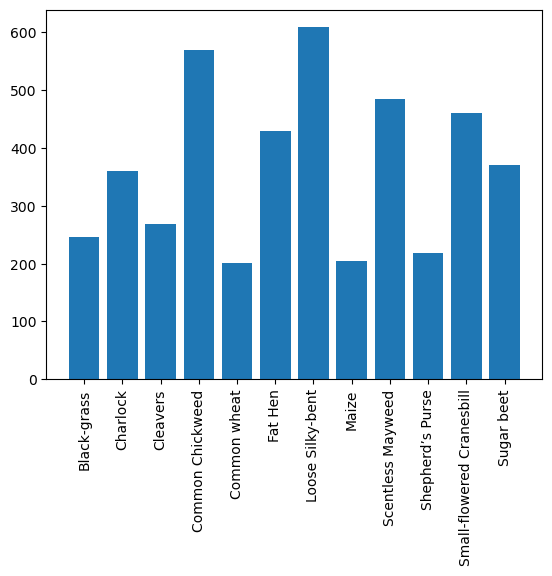

In [10]:
count_plot=np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

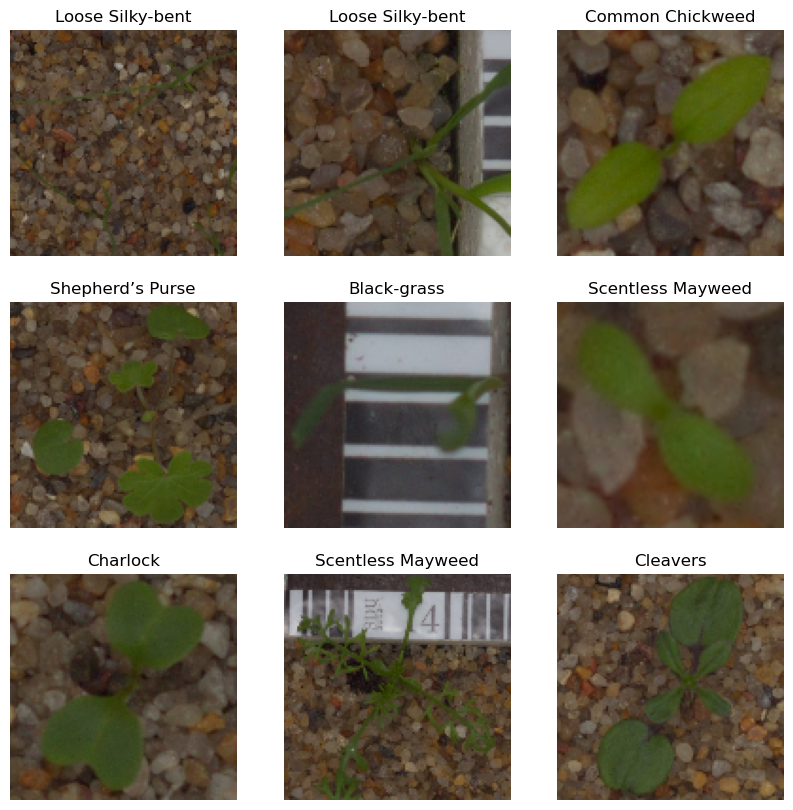

In [11]:
# visualizing few images from the train data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

Creating model

In [12]:
input_shape=(120, 120, 3)
num_classes=12

model=Sequential()
model.add(tf.keras.layers.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))   
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

c:\Users\shrir\anaconda3\envs\Visioguide\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\shrir\anaconda3\envs\Visioguide\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 120, 120, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 118, 118, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 118, 118, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 118, 118, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 57, 57, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             

 Total params: 5,829,932 (22.24 MB)

 Trainable params: 5,829,036 (22.24 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
epochs=18
batch_size=32
history=model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.3624 - loss: 8.1488 - val_accuracy: 0.0464 - val_loss: 21.4698
Epoch 2/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 101s 956ms/step - accuracy: 0.6793 - loss: 1.1212 - val_accuracy: 0.1165 - val_loss: 19.6955
Epoch 3/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.8057 - loss: 0.6004 - val_accuracy: 0.0892 - val_loss: 17.9397
Epoch 4/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.8767 - loss: 0.3952 - val_accuracy: 0.1760 - val_loss: 8.9606
Epoch 5/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.9033 - loss: 0.3119 - val_accuracy: 0.4114 - val_loss: 3.7321
Epoch 6/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 101s 950ms/step - accuracy: 0.9335 - loss: 0.1930 - val_accuracy: 0.7015 - val_loss: 1.4127
Epoch 7/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 96s 901ms/step - accuracy: 0.9412 - loss: 0.1750 - val_accuracy: 0.6480 - val_loss: 2.0154
Epoch 8/18
106/106 ━━━━━━━━━━━━━━━━━━━━ 99s 937ms/step - accuracy: 0.9157 - loss: 0.31

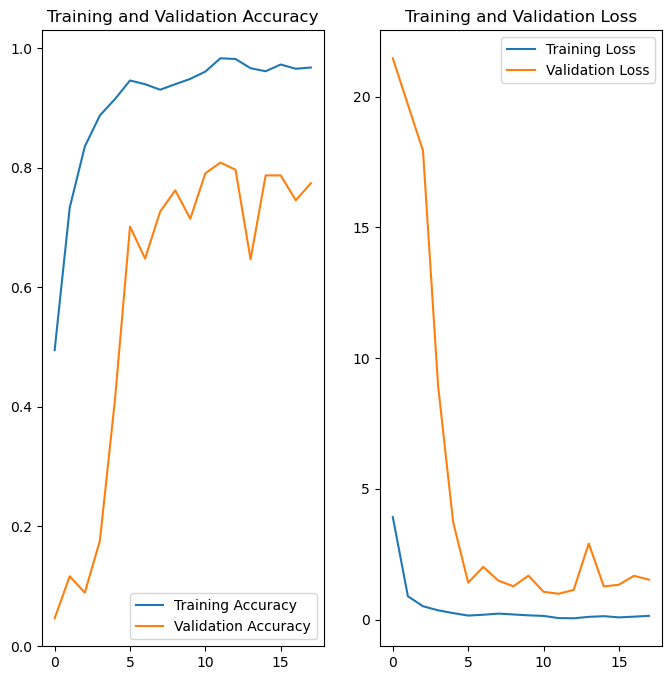

In [16]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 2: Applied dropouts

In [17]:
input_shape=(120, 120, 3)
num_classes=12

model2=Sequential()
model2.add(tf.keras.layers.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model2.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20)) # Dropout to ignore 20% of the neurons and avoid overfitting

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Flatten())
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dropout(0.20))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

c:\Users\shrir\anaconda3\envs\Visioguide\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\shrir\anaconda3\envs\Visioguide\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
opt=Adam(learning_rate=0.0001)
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
# specifying the format in which model needs to be saved
model_name = 'Seed2' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.keras'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [22]:
epochs=15
batch_size=32
history=model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)    

Epoch 1/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.1619 - loss: 2.3742
Epoch 1: val_loss improved from inf to 1.97289, saving model to Seed2/model-00001-2.30285-1.97289-.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 57s 505ms/step - accuracy: 0.1622 - loss: 2.3735 - val_accuracy: 0.3448 - val_loss: 1.9729
Epoch 2/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.3919 - loss: 1.7519
Epoch 2: val_loss improved from 1.97289 to 1.45198, saving model to Seed2/model-00002-1.63276-1.45198-.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 50s 468ms/step - accuracy: 0.3923 - loss: 1.7508 - val_accuracy: 0.4946 - val_loss: 1.4520
Epoch 3/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.5117 - loss: 1.3957
Epoch 3: val_loss improved from 1.45198 to 1.22141, saving model to Seed2/model-00003-1.35385-1.22141-.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 434ms/step - accuracy: 0.5119 - loss: 1.3953 - val_accuracy: 0.5779 - val_loss: 1.2214
Epoch 4/15
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step

In [23]:
img=keras.preprocessing.image.load_img('C:/TMLC/PROJECT 7/Data/test/Black-grass/2.png', target_size=(120, 120))

In [24]:
prediction=model.predict(keras.preprocessing.image.img_to_array(img).reshape(1, 120, 120, 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step


In [25]:
prediction

array([[1.5377591e-04, 2.5812067e-12, 3.9558223e-08, 8.4791122e-07,
        1.6209358e-07, 9.6473831e-01, 3.5080682e-02, 1.0038120e-08,
        2.5803638e-05, 4.8625338e-08, 4.5581825e-07, 1.3608056e-11]],
      dtype=float32)

In [26]:
predicted_class = np.argmax(prediction, axis=-1)
print(f'Predicted class: {predicted_class[0]}')


Predicted class: 5


Creating model 3

In [16]:
input_shape=(120, 120, 3)
num_classes=12

model_aug=Sequential()
model_aug.add(tf.keras.layers.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model_aug.add(tf.keras.layers.RandomFlip("horizontal_and_vertical"))
model_aug.add(tf.keras.layers.RandomRotation(0.2))
model_aug.add(Conv2D(32, (3, 3), input_shape=input_shape, padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(32, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(64, (3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(64, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(128, (3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(128, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Flatten())
model_aug.add(Dense(512))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.20))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

c:\Users\shrir\anaconda3\envs\Visioguide\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\shrir\anaconda3\envs\Visioguide\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
opt=Adam(0.001)
model_aug.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_aug.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 120, 120, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 120, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 120, 120, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 118, 118, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 118, 118, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 57, 57, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 57, 57, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    11,076,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 11,369,260 (43.37 MB)

 Trainable params: 11,369,260 (43.37 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# spefying the format in which model needs to be saved
model_name = 'Seed3' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.keras'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [22]:
epochs=12
batch_size=32
history=model_aug.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.1623 - loss: 2.4326
Epoch 1: val_loss improved from inf to 1.59185, saving model to Seed3/model-00001-2.11088-1.59185-.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 61s 538ms/step - accuracy: 0.1632 - loss: 2.4296 - val_accuracy: 0.4150 - val_loss: 1.5919
Epoch 2/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.4550 - loss: 1.5271
Epoch 2: val_loss improved from 1.59185 to 1.14382, saving model to Seed3/model-00002-1.43819-1.14382-.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 56s 525ms/step - accuracy: 0.4553 - loss: 1.5263 - val_accuracy: 0.5910 - val_loss: 1.1438
Epoch 3/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6061 - loss: 1.1293
Epoch 3: val_loss improved from 1.14382 to 0.94646, saving model to Seed3/model-00003-1.09016-0.94646-.keras
106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 504ms/step - accuracy: 0.6062 - loss: 1.1289 - val_accuracy: 0.6671 - val_loss: 0.9465
Epoch 4/12
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step

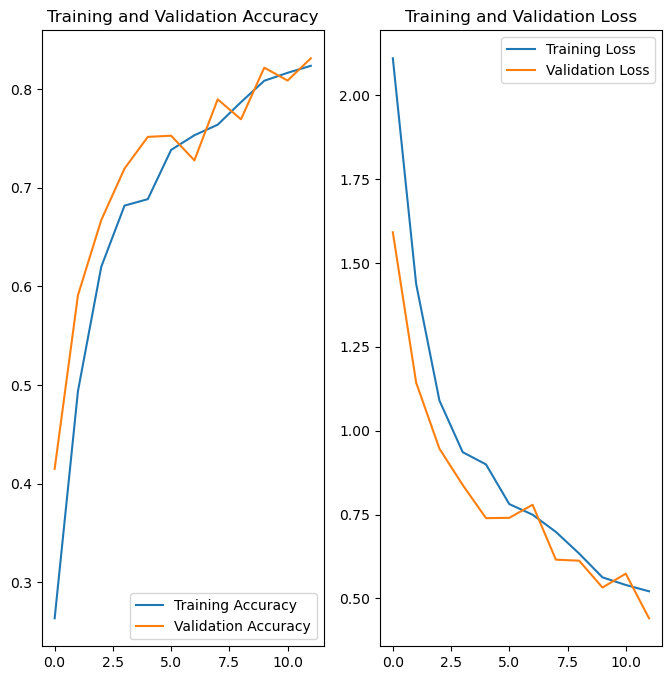

In [23]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(12)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model 4: Dealing with clas imbalance

In [27]:
train_path = 'C:/TMLC/PROJECT 7/Data/train/'
test_path = 'C:/TMLC/PROJECT 7/Data/test/'

for i in labels:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.png')))
    print(f'{i} has {length} samples.')

Black-grass has 247 samples.
Charlock has 361 samples.
Cleavers has 268 samples.
Common Chickweed has 570 samples.
Common wheat has 202 samples.
Fat Hen has 430 samples.
Loose Silky-bent has 609 samples.
Maize has 205 samples.
Scentless Mayweed has 485 samples.
Shepherd’s Purse has 219 samples.
Small-flowered Cranesbill has 460 samples.
Sugar beet has 370 samples.


In [29]:
!pip install Augmentor

  Obtaining dependency information for Augmentor from https://files.pythonhosted.org/packages/f3/86/5a91176650eb229ea2cd95551c34c36fba6cd95da3bdc4a5c73fbb1536ca/Augmentor-0.2.12-py2.py3-none-any.whl.metadata


In [30]:
path_to_training_dataset=train_path

import Augmentor
for i in labels:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 247 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Black-grass\output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=82x82 at 0x1ADE04E0E50>: 100%|██████████| 500/500 [00:38<00:00, 13.01 Samples/s]    


Initialised with 361 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Charlock\output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=299x299 at 0x1ADA3C05750>: 100%|██████████| 500/500 [00:16<00:00, 29.87 Samples/s]  


Initialised with 268 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Cleavers\output.

Processing <PIL.Image.Image image mode=RGB size=443x443 at 0x1ADD01CE250>: 100%|██████████| 500/500 [00:08<00:00, 62.37 Samples/s]                


Initialised with 570 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Common Chickweed\output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=88x88 at 0x1ADA3C35BD0>: 100%|██████████| 500/500 [00:06<00:00, 81.85 Samples/s]   


Initialised with 202 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Common wheat\output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=166x166 at 0x1ADD0155050>: 100%|██████████| 500/500 [00:20<00:00, 24.86 Samples/s]  


Initialised with 430 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Fat Hen\output.

Processing <PIL.Image.Image image mode=RGB size=549x549 at 0x1ADA0176B50>: 100%|██████████| 500/500 [00:10<00:00, 49.90 Samples/s]                  


Initialised with 609 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Loose Silky-bent\output.

Processing <PIL.Image.Image image mode=RGB size=121x121 at 0x1ADA03D4490>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]                  


Initialised with 205 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Maize\output.

Processing <PIL.Image.Image image mode=RGB size=834x834 at 0x1ADD023D350>: 100%|██████████| 500/500 [00:29<00:00, 17.10 Samples/s]                  


Initialised with 485 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Scentless Mayweed\output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=100x100 at 0x1ADDF0C39D0>: 100%|██████████| 500/500 [00:09<00:00, 54.45 Samples/s] 


Initialised with 219 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Shepherd’s Purse\output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=168x168 at 0x1ADA038AC50>: 100%|██████████| 500/500 [00:10<00:00, 49.61 Samples/s]  


Initialised with 460 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Small-flowered Cranesbill\output.

Processing <PIL.Image.Image image mode=RGB size=178x178 at 0x1ADD0150D50>: 100%|██████████| 500/500 [00:10<00:00, 48.58 Samples/s]                


Initialised with 370 image(s) found.
Output directory set to C:/TMLC/PROJECT 7/Data/train/Sugar beet\output.

Processing <PIL.Image.Image image mode=RGB size=579x579 at 0x1ADA03EA890>: 100%|██████████| 500/500 [00:23<00:00, 21.57 Samples/s]                  


In [31]:
for i in labels:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.png')))
    length_out=len(list(class_directory_out.glob('*.png')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

Black-grass has 747 samples.
Charlock has 861 samples.
Cleavers has 768 samples.
Common Chickweed has 1070 samples.
Common wheat has 702 samples.
Fat Hen has 930 samples.
Loose Silky-bent has 1109 samples.
Maize has 705 samples.
Scentless Mayweed has 985 samples.
Shepherd’s Purse has 719 samples.
Small-flowered Cranesbill has 960 samples.
Sugar beet has 870 samples.


In [34]:
batch_size = 32
img_height = 120
img_width = 120

data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_path,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 9707 files belonging to 11 classes.
Using 7766 files for training.


In [35]:
train_ds.class_names

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9707 files belonging to 11 classes.
Using 1941 files for validation.


In [38]:
input_shape = (120,120,3)
num_classes = 11

model4 = Sequential()
model4.add(tf.keras.layers.Rescaling(1./255, offset=0.0))
model4.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(32, kernel_size=(3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

c:\Users\shrir\anaconda3\envs\Visioguide\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
### choosing an appropirate optimiser and loss function
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# spefying the format in which model needs to be saved
model_name = 'Seed4' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.keras'
# Creating the call back for saving only the best models
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [41]:
epochs=15
batch_size=32
history=model4.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.1610 - loss: 2.2746
Epoch 1: val_loss improved from inf to 1.42009, saving model to Seed4/model-00001-1.99677-1.42009-.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 112s 444ms/step - accuracy: 0.1614 - loss: 2.2735 - val_accuracy: 0.4781 - val_loss: 1.4201 - learning_rate: 0.0010
Epoch 2/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5421 - loss: 1.2615
Epoch 2: val_loss improved from 1.42009 to 0.76809, saving model to Seed4/model-00002-1.08466-0.76809-.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 105s 429ms/step - accuracy: 0.5423 - loss: 1.2608 - val_accuracy: 0.7161 - val_loss: 0.7681 - learning_rate: 0.0010
Epoch 3/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.7236 - loss: 0.7702
Epoch 3: val_loss improved from 0.76809 to 0.62750, saving model to Seed4/model-00003-0.66765-0.62750-.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 113s 463ms/step - accuracy: 0.7237 - loss: 0.7698 - val_accuracy: 0.7913 - val_loss: 0.6275 - 

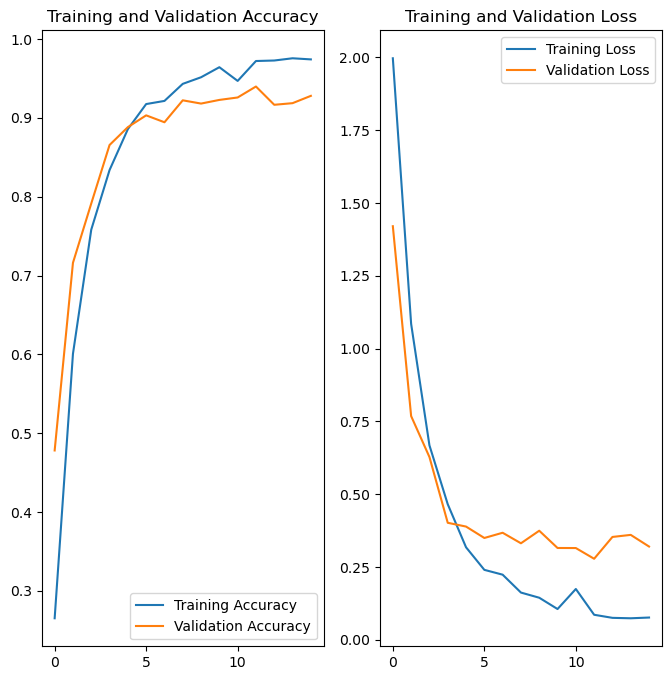

In [42]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This comes down to be our best model.
Firstly we used Augmentor to increas frequency for each class.
Model: Resampling->conv2D->Activation->Conv2D->Activation->MaxPooling->Dropout